# English League Analytics 

# Seasons: 2008/2009 - 2015/2016

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

plt.rcParams['figure.figsize'] = 8, 7
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "normal"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['axes.labelsize']=18
plt.rcParams['legend.fontsize']: 16
    
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
### Setting Up DB Connection ###
db = 'database.sqlite'
conn = sqlite3.connect(db)

### Extracting All Available Tables From DB ###
db_tables = pd.read_sql("""SELECT * 
                            FROM sqlite_master
                            WHERE type='table';""", conn)
print(db_tables)

    type               name           tbl_name  rootpage                                                sql
0  table    sqlite_sequence    sqlite_sequence         4             CREATE TABLE sqlite_sequence(name,seq)
1  table  Player_Attributes  Player_Attributes        11  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...
2  table             Player             Player        14  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3  table              Match              Match        18  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4  table             League             League        24  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5  table            Country            Country        26  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6  table               Team               Team        29  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...
7  table    Team_Attributes    Team_Attributes         2  CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [674]:
# Average Number of Matches Played in Each League per Season (08/09 - 15/16)# 
avg_games = pd.read_sql("""SELECT c.name AS Country, l.name AS League, (COUNT(c.name) / COUNT(DISTINCT m.season)) AS Avg_Games_Season
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                WHERE c.name = 'England'
                                GROUP BY c.name
                                ORDER BY (COUNT(c.name) / COUNT(DISTINCT m.season)) DESC""", conn)
print(avg_games)

   Country                  League  Avg_Games_Season
0  England  England Premier League               380


In [678]:
### Number of Teams Per League Per Season ###
team_count = pd.read_sql("""SELECT m.season, c.name AS Country, l.name AS League, COUNT (DISTINCT t.team_long_name) AS num_teams
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                INNER JOIN Team as t
                                ON m.home_team_api_id = t.team_api_id
                                WHERE c.name = 'England'
                                GROUP BY c.name, m.season
                                """, conn)
print(team_count.groupby(['League'])['num_teams'].mean().reset_index())

                   League  num_teams
0  England Premier League         20


In [680]:
### Goals Per Game Statistics ###
match_stats = pd.read_sql("""SELECT c.name AS Country, l.name as League, AVG(m.home_team_goal) AS home_goals, AVG(m.away_team_goal) AS away_goals, AVG(m.home_team_goal + m.away_team_goal) AS total_goals, 
                                ABS(AVG(m.home_team_goal - m.away_team_goal)) AS goal_diff
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                WHERE c.name IN ('England')
                                GROUP BY c.name, l.name
                                ORDER BY AVG(m.home_team_goal + m.away_team_goal) DESC""", conn)
print(match_stats)

   Country                  League  home_goals  away_goals  total_goals  goal_diff
0  England  England Premier League    1.550987    1.159539     2.710526   0.391447


**As could be anticipated, the home team scored more goals on average. Below, let's see which season contained the best home field advantage for goal scoring**

In [689]:
### Which season were the home fans the best/worst?? (home field advantage) ###
english_goals = pd.read_sql("""SELECT m.season, AVG(m.home_team_goal - m.away_team_goal) AS 'diff(home-away goals per game)'
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                WHERE c.name = 'England'
                                GROUP BY m.season
                                ORDER BY AVG(m.home_team_goal - m.away_team_goal) """, conn)
print(english_goals)

      season  diff(home-away goals per game)
0  2015/2016                        0.284211
1  2012/2013                        0.318421
2  2008/2009                        0.321053
3  2011/2012                        0.373684
4  2013/2014                        0.378947
5  2014/2015                        0.381579
6  2010/2011                        0.450000
7  2009/2010                        0.623684


**The difference in the amount of goals the home team scored versus the away team was at its lowest during the 2015/2016 season and at its highest during the 2009/2010 season**

# Which Season Was the Most Exciting For Fans Who Love Goals??

In [690]:
### Seasonal Goals Breakdown ###
english_goals = pd.read_sql("""SELECT m.season, AVG(m.home_team_goal) AS home_goals, AVG(m.away_team_goal) AS away_goals, AVG(m.home_team_goal + m.away_team_goal) AS goals_per_game, SUM(m.home_team_goal + m.away_team_goal) AS total_goals
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                WHERE c.name = 'England'
                                GROUP BY m.season""", conn)
print(english_goals)

      season  home_goals  away_goals  goals_per_game  total_goals
0  2008/2009    1.400000    1.078947        2.478947          942
1  2009/2010    1.697368    1.073684        2.771053         1053
2  2010/2011    1.623684    1.173684        2.797368         1063
3  2011/2012    1.589474    1.215789        2.805263         1066
4  2012/2013    1.557895    1.239474        2.797368         1063
5  2013/2014    1.573684    1.194737        2.768421         1052
6  2014/2015    1.473684    1.092105        2.565789          975
7  2015/2016    1.492105    1.207895        2.700000         1026


**The 2011/2012 season was the most exciting for fans who love goals**

# Which Team Won the Most Premier League Titles During this Time??

In [683]:
### Gathering Premier League Matches ###
matches = pd.read_sql("""SELECT m.season, l.name, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal
                            FROM Match as m
                            INNER JOIN League as l
                            ON m.league_id = l.id
                            WHERE l.name = 'England Premier League'""", conn)
print(matches.head(5))

# add win/loss/tie points for both home and away #
matches['home_points'] = ''
matches['away_points'] = ''
for idx, row in matches.iterrows():
    if row['home_team_goal'] > row['away_team_goal']:
        matches.loc[idx, 'home_points'] = 3
        matches.loc[idx, 'away_points'] = 0
    elif row['home_team_goal'] < row['away_team_goal']:
        matches.loc[idx, 'home_points'] = 0
        matches.loc[idx, 'away_points'] = 3
    else:
        matches.loc[idx, 'home_points'] = 1
        matches.loc[idx, 'away_points'] = 1

print('\nAdding points awarded to each team after game', '\n')
print(matches[['home_team_goal', 'away_team_goal', 'home_points', 'away_points']].head(5))

      season                    name  home_team_api_id  away_team_api_id  home_team_goal  away_team_goal
0  2008/2009  England Premier League             10260             10261               1               1
1  2008/2009  England Premier League              9825              8659               1               0
2  2008/2009  England Premier League              8472              8650               0               1
3  2008/2009  England Premier League              8654              8528               2               1
4  2008/2009  England Premier League             10252              8456               4               2

Adding points awarded to each team after game 

   home_team_goal  away_team_goal  home_points  away_points
0               1               1            1            1
1               1               0            3            0
2               0               1            0            3
3               2               1            3            0
4               4    

In [684]:
### Assigning Team Names based on api_id ###

teams = pd.read_sql("""SELECT team_api_id, team_long_name
                        FROM Team""", conn)

for idx, row in matches.iterrows():
    for idx2, row2 in teams.iterrows():
        if row['home_team_api_id'] == row2['team_api_id']:
            matches.loc[idx, 'home_team_api_id'] = row2['team_long_name']
        elif row['away_team_api_id'] == row2['team_api_id']:
            matches.loc[idx, 'away_team_api_id'] = row2['team_long_name']

matches.columns = ['season', 'league', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 'home_points', 'away_points']
print(matches.head(3))

      season                  league          home_team             away_team  home_team_goal  away_team_goal  home_points  away_points
0  2008/2009  England Premier League  Manchester United      Newcastle United               1               1            1            1
1  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0            3            0
2  2008/2009  England Premier League         Sunderland             Liverpool               0               1            0            3


In [686]:
# Home Points #
home = matches.groupby(['season', 'league', 'home_team'])['home_points'].sum()
home = home.reset_index()
home.columns = ['season', 'league', 'team', 'home_points']

# Away Point #
away = matches.groupby(['season', 'league', 'away_team'])['away_points'].sum()
away = away.reset_index()
away.columns = ['season', 'league', 'team', 'away_points']

### Total Points ###
total = pd.merge(home, away, on=['season', 'league', 'team'], how='inner')
total['total_points'] = total['home_points'] + total['away_points']
print(total.head(3))

      season                  league              team  home_points  away_points  total_points
0  2008/2009  England Premier League           Arsenal           38           34            72
1  2008/2009  England Premier League       Aston Villa           30           32            62
2  2008/2009  England Premier League  Blackburn Rovers           25           16            41


In [688]:
### Which Team Was the Most Dominate During this Period of Time?? ###

for season in list(total.season.unique()):
    result = total.loc[(total['league'] == league) & (total['season'] == season)]
    winner = result.loc[result['total_points'] == max(result['total_points'])]['team']
    most_frequent = max(set(champions), key=champions.count)
print(most_frequent + ': ', str(champions.count(most_frequent)) + ' league titles')

Manchester United:  3 league titles


# Manchester United Won the League the Most Times During This Particular Period in Time, But Who Were the Other Champions and When Did They Win the League??

In [346]:
### League Champs Per Season ### 
england = total.loc[total['league'] == 'England Premier League']
for season in list(england['season'].unique()):
    season_df = england.loc[(england['season'] == season) & (england['league'] == 'England Premier League')]
    champ = season_df.loc[season_df['total_points'] == max(season_df['total_points'])]['team'].unique()[0]
    for idx, row in england.iterrows():
        if row['season'] == season:
            england.loc[idx, 'Champion'] = champ
champs = pd.DataFrame(england.groupby('season')['Champion'].agg(pd.Series.mode).reset_index())
print(champs)

      season           Champion
0  2008/2009  Manchester United
1  2009/2010            Chelsea
2  2010/2011  Manchester United
3  2011/2012    Manchester City
4  2012/2013  Manchester United
5  2013/2014    Manchester City
6  2014/2015            Chelsea
7  2015/2016     Leicester City


# What Makes a Champion a Champion? Can We Find Any Common Traits Among the Champions of Each Season?


# Part I (Offense) : Who Scored the Most Goals Per Season (home/away/total) Compared to Champion of that Season??

In [695]:
import collections

# Home Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['home_goals'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['home_goals'] == max(season_df['home_goals'])]
    max_goals.columns = ['season', 'most_home_goals', 'home_goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_home_goals']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season    most_home_goals  home_goals           champion  champ_home_goals
0  2008/2009  Manchester United          43  Manchester United                43
1  2009/2010            Chelsea          68            Chelsea                68
2  2010/2011  Manchester United          49  Manchester United                49
3  2011/2012    Manchester City          55    Manchester City                55
4  2012/2013            Arsenal          47  Manchester United                45
5  2013/2014    Manchester City          63    Manchester City                63
6  2014/2015    Manchester City          44            Chelsea                36
7  2015/2016    Manchester City          47     Leicester City                35


**In 5 Out of 8 Seasons (~ 63%), The Team Who Scored the Most Home Goals Became Champions**

In [696]:
# Away Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['away_team'].unique()):
        season_team = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_team['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['away_goals'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['away_goals'] == max(season_df['away_goals'])]
    max_goals.columns = ['season', 'most_away_goals', 'away_goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_away_goals']
    season_champs.append(champ_goals)
away_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
away_champion = pd.merge(away_goals, champs_goals, how='inner', on='season')
print(away_champion)

      season    most_away_goals  away_goals           champion  champ_away_goals
0  2008/2009            Arsenal          37  Manchester United                25
1  2009/2010            Arsenal          35            Chelsea                35
2  2009/2010            Chelsea          35            Chelsea                35
3  2010/2011            Arsenal          39  Manchester United                29
4  2011/2012    Manchester City          38    Manchester City                38
5  2012/2013  Manchester United          41  Manchester United                41
6  2013/2014          Liverpool          48    Manchester City                39
7  2014/2015    Manchester City          39            Chelsea                37
8  2015/2016  Tottenham Hotspur          34     Leicester City                33
9  2015/2016            Arsenal          34     Leicester City                33


**In 3 Out of 8 Seasons (~ 38%), The Team Who Scored the Most Away Goals Became Champions**

In [697]:
# Total Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_home = total_goals.loc[total_goals['home_team'] == team]
        season_away = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_home['home_team_goal'])
        team_away_goals = np.sum(season_away['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['total_goals'].append(team_home_goals + team_away_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['total_goals'] == max(season_df['total_goals'])]
    max_goals.columns = ['season', 'most_goals', 'goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals']
    season_champs.append(champ_goals)
total_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
offense = pd.merge(total_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season    most_home_goals  home_goals           champion  champ_home_goals
0  2008/2009  Manchester United          43  Manchester United                43
1  2009/2010            Chelsea          68            Chelsea                68
2  2010/2011  Manchester United          49  Manchester United                49
3  2011/2012    Manchester City          55    Manchester City                55
4  2012/2013            Arsenal          47  Manchester United                45
5  2013/2014    Manchester City          63    Manchester City                63
6  2014/2015    Manchester City          44            Chelsea                36
7  2015/2016    Manchester City          47     Leicester City                35


**In 5 Out of 8 Seasons (~ 63%), The Team Who Scored the Most Goals (Home & Away) Became Champions**

# Part II (Defense): Does Defense Really Win Championships? Goals Against - (Home/Away/Total)

In [698]:
# Home Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against(home)'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against(home)'] == min(season_df['goals_against(home)'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against(home)']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against(home)']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

       season least_goals_against  goals_against(home)           champion  champ_goals_against(home)
0   2008/2009   Tottenham Hotspur                   10  Manchester United                         13
1   2009/2010   Manchester United                   12            Chelsea                         14
2   2009/2010   Tottenham Hotspur                   12            Chelsea                         14
3   2010/2011   Manchester United                   12  Manchester United                         12
4   2010/2011     Manchester City                   12  Manchester United                         12
5   2011/2012     Manchester City                   12    Manchester City                         12
6   2012/2013     Manchester City                   15  Manchester United                         19
7   2013/2014             Arsenal                   11    Manchester City                         13
8   2013/2014             Chelsea                   11    Manchester City                  

**In 3 Out of 8 Seasons (~ 38%), The Team Who Let in the Fewest Goals at Home Became Champions**

In [699]:
# Away Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_team['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against(away)'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against(away)'] == min(season_df['goals_against(away)'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against(away)']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against(away)']
    season_champs.append(champ_goals)
away_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(away_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season least_goals_against  goals_against(away)           champion  champ_goals_against(away)
0  2008/2009   Manchester United                   11  Manchester United                         11
1  2009/2010   Manchester United                   16            Chelsea                         18
2  2010/2011             Chelsea                   20  Manchester United                         25
3  2010/2011              Fulham                   20  Manchester United                         25
4  2011/2012   Manchester United                   14    Manchester City                         17
5  2012/2013             Arsenal                   14  Manchester United                         24
6  2013/2014             Chelsea                   16    Manchester City                         24
7  2014/2015         Southampton                   20            Chelsea                         23
8  2015/2016      Leicester City                   18     Leicester City                         18


**In 2 Out of 8 Seasons (~ 25%), The Team Who Let In the Least Amount of Away Goals Became Champions**

In [700]:
# Total Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team_home = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team_home['away_team_goal'])
        season_team_away = total_goals.loc[total_goals['away_team'] == team]
        team_away_goals = np.sum(season_team_away['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against'].append(team_home_goals + team_away_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against'] == min(season_df['goals_against'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against']
    season_champs.append(champ_goals)
total_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
defense = pd.merge(total_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season least_goals_against  goals_against(away)           champion  champ_goals_against(away)
0  2008/2009   Manchester United                   11  Manchester United                         11
1  2009/2010   Manchester United                   16            Chelsea                         18
2  2010/2011             Chelsea                   20  Manchester United                         25
3  2010/2011              Fulham                   20  Manchester United                         25
4  2011/2012   Manchester United                   14    Manchester City                         17
5  2012/2013             Arsenal                   14  Manchester United                         24
6  2013/2014             Chelsea                   16    Manchester City                         24
7  2014/2015         Southampton                   20            Chelsea                         23
8  2015/2016      Leicester City                   18     Leicester City                         18


**In 3 Out of 8 Seasons (~ 38%), The Team Who Let In The Least Amount of Goals Became Champions**

# Insights: 

# In 5 Out of 8 Seasons (~ 63%), The Team Who Scored the Most Goals (Home & Away) Became Champions
# In 3 Out of 8 Seasons (~ 38%), The Team Who Let In The Least Amount of Goals (Home & Away) Became Champions

# During this Period of Time, it Looks Like Offense Won Championships More Often Than Defense

# Being a Champion Usually Takes a Combination of Both Offense and Defense, So in How Many Season Was The Champion the Team Who Scored the Most Goals AND Let In the Least Amount of Goals?? 

In [703]:
off_def = pd.merge(offense, defense, how='inner', on=['season', 'champion'])[['season', 'champion', 'most_goals', 'least_goals_against']]
print(off_def)

       season           champion         most_goals least_goals_against
0   2008/2009  Manchester United          Liverpool   Manchester United
1   2008/2009  Manchester United          Liverpool             Chelsea
2   2009/2010            Chelsea            Chelsea   Manchester United
3   2010/2011  Manchester United  Manchester United             Chelsea
4   2010/2011  Manchester United  Manchester United     Manchester City
5   2011/2012    Manchester City    Manchester City     Manchester City
6   2012/2013  Manchester United  Manchester United     Manchester City
7   2013/2014    Manchester City    Manchester City             Chelsea
8   2014/2015            Chelsea    Manchester City             Chelsea
9   2015/2016     Leicester City    Manchester City   Manchester United
10  2015/2016     Leicester City    Manchester City   Tottenham Hotspur


# Only Manchester City in 2011/2012 Were So Dominant That They Scored the Most Goals AND Let In The Fewest Goals



# What Was The Average Record Needed to Win the League? Where (Home/Away) Did the Champion Earn Their Points?  

In [704]:
### Points Percentages ###
total_england = total.loc[total['league'] == 'England Premier League']
champs.columns = ['season', 'team']
champ_points = pd.merge(champs, total_england, how='inner', on=['season', 'team'])
champ_points['home(%)'] = champ_points['home_points'] / champ_points['total_points']
champ_points['away(%)'] = champ_points['away_points'] / champ_points['total_points']
print(champ_points)

      season               team                  league  home_points  away_points  total_points   home(%)   away(%)
0  2008/2009  Manchester United  England Premier League           50           40            90  0.555556  0.444444
1  2009/2010            Chelsea  England Premier League           52           34            86  0.604651  0.395349
2  2010/2011  Manchester United  England Premier League           55           25            80  0.687500  0.312500
3  2011/2012    Manchester City  England Premier League           55           34            89  0.617978  0.382022
4  2012/2013  Manchester United  England Premier League           48           41            89  0.539326  0.460674
5  2013/2014    Manchester City  England Premier League           52           34            86  0.604651  0.395349
6  2014/2015            Chelsea  England Premier League           49           38            87  0.563218  0.436782
7  2015/2016     Leicester City  England Premier League           42    

**Manchester United was the most reliant on their home performances to become champions in the 2010/2011 season** 

**Leicester City was the least reliant on their home performances to become champions in the 2015/2016 season**

# Summary of Points Needed to Become Champion

In [176]:
summary = champ_points.groupby('league')[['home_points', 'away_points', 'total_points', 'home(%)', 'away(%)']].mean()
print(summary)

                        home_points  away_points  total_points   home(%)   away(%)
league                                                                            
England Premier League       50.375       35.625          86.0  0.586425  0.413575


# Where do the points come from? Summarizing the Records of the Champions Throughout the Seasons

In [705]:
english_matches = matches.loc[matches['league'] == 'England Premier League']

champ_record = collections.defaultdict(list)
for season in list(champ_points.season.unique()):
    english_season = english_matches.loc[english_matches['season'] == season]
    for team in list(champ_points.loc[champ_points['season'] == season].team.unique()):
        champ_season = english_season.loc[(english_season['home_team'] == team) | (english_season['away_team'] == team)]
        home_win = 0
        home_tie = 0
        home_loss = 0
        away_win = 0
        away_tie = 0
        away_loss = 0
        for idx, row in champ_season.iterrows():
            if row['home_team'] == team and row['home_team_goal'] > row['away_team_goal']:
                home_win += 1
            elif row['home_team'] == team and row['home_team_goal'] == row['away_team_goal']:
                home_tie += 1
            elif row['home_team'] == team and row['home_team_goal'] < row['away_team_goal']:
                home_loss += 1
            if row['away_team'] == team and row['home_team_goal'] < row['away_team_goal']:
                away_win += 1
            elif row['away_team'] == team and row['home_team_goal'] == row['away_team_goal']:
                away_tie += 1
            elif row['away_team'] == team and row['home_team_goal'] > row['away_team_goal']:
                away_loss += 1
        champ_record['season'].append(season)
        champ_record['team'].append(team)
        champ_record['home_wins'].append(home_win)
        champ_record['away_wins'].append(away_win)
        champ_record['home_tie'].append(home_tie)
        champ_record['away_tie'].append(away_tie)
        champ_record['home_loss'].append(home_loss)
        champ_record['away_loss'].append(away_loss)
records = pd.DataFrame(champ_record)
print(records)                
        

      season               team  home_wins  away_wins  home_tie  away_tie  home_loss  away_loss
0  2008/2009  Manchester United         16         12         2         4          1          3
1  2009/2010            Chelsea         17         10         1         4          1          5
2  2010/2011  Manchester United         18          5         1        10          0          4
3  2011/2012    Manchester City         18         10         1         4          0          5
4  2012/2013  Manchester United         16         12         0         5          3          2
5  2013/2014    Manchester City         17         10         1         4          1          5
6  2014/2015            Chelsea         15         11         4         5          0          3
7  2015/2016     Leicester City         12         11         6         6          1          2


**Manchester United (2010/2011), Manchester City (2011/2012), and Chelsea (2014/2015) Were the Only Champs to go Undefeated at Home**

**No Champion Went Undefeated Away from Home**

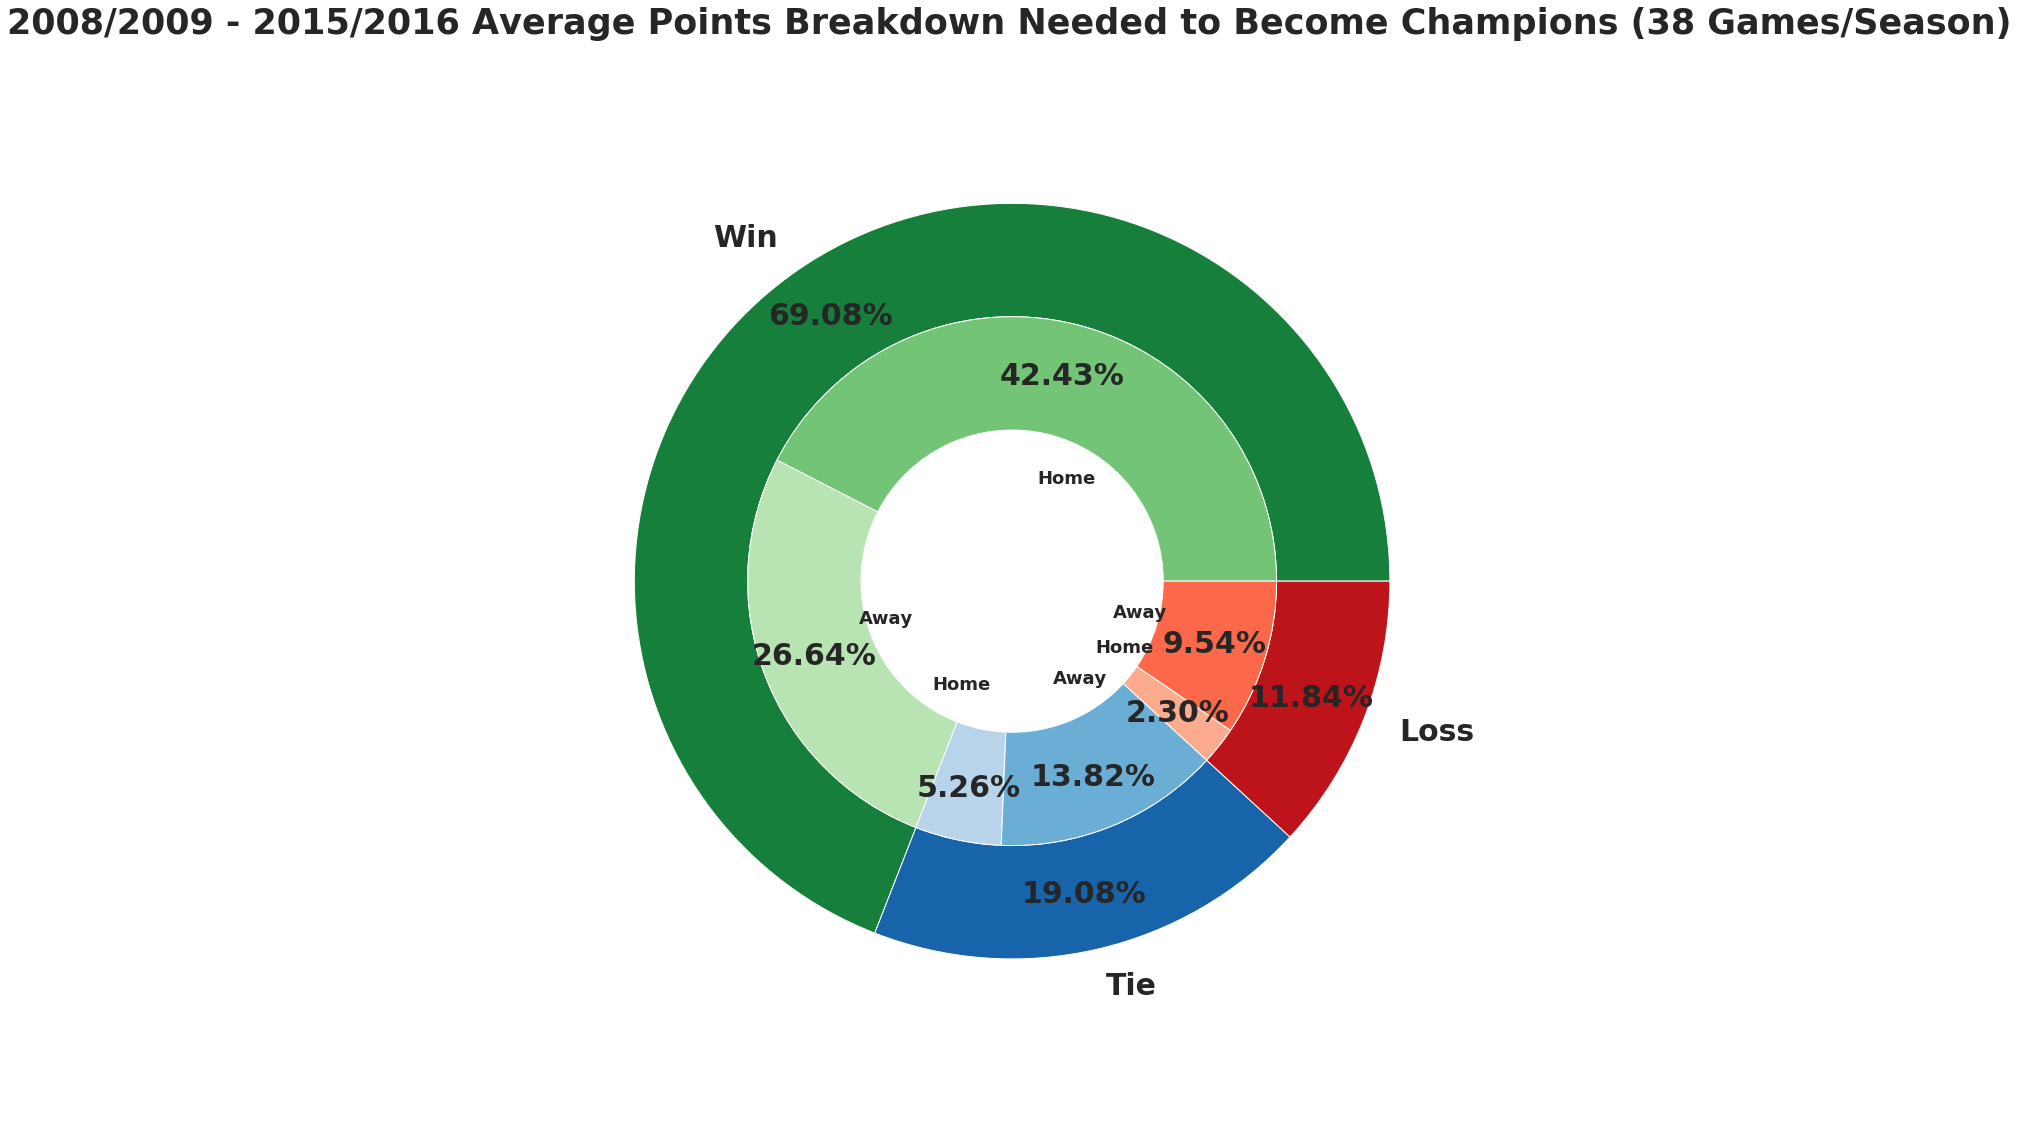

                   league  home_wins  away_wins  home_tie  away_tie  home_loss  away_loss  total_wins  total_tie  total_loss
0  England Premier League     16.125     10.125       2.0      5.25      0.875      3.625       26.25       7.25         4.5


In [706]:
records['total_wins'] = records['home_wins'] + records['away_wins']
records['total_loss'] = records['home_loss'] + records['away_loss']
records['total_tie'] = records['home_tie'] + records['away_tie']
records['league'] = 'England Premier League'
record_summary = records.groupby('league')[['home_wins', 'away_wins', 'home_tie', 'away_tie', 'home_loss', 'away_loss', 'total_wins',
                                'total_tie', 'total_loss']].mean().reset_index()

plt.rcParams['figure.figsize'] = 15, 20

group_names=['Win', 'Tie', 'Loss']
group_size=[record_summary.loc[:, 'total_wins'][0], record_summary.loc[:, 'total_tie'][0], record_summary.loc[:, 'total_loss'][0]]
subgroup_names=['Home', 'Away', 'Home', 'Away', 'Home', 'Away']
subgroup_size=[record_summary.loc[:, 'home_wins'][0], record_summary.loc[:, 'away_wins'][0], record_summary.loc[:, 'home_tie'][0],
              record_summary.loc[:, 'away_tie'][0], record_summary.loc[:, 'home_loss'][0], record_summary.loc[:, 'away_loss'][0]]
 
plt.rcParams["font.size"] = 30


wedges, labels, autopct = plt.pie(group_size, radius=1,
        colors=[a(0.8), b(0.8), c(0.8)],
        labels=group_names, autopct='%.2f%%',
        pctdistance=0.85,
        wedgeprops=dict(width=0.3, edgecolor='white'))

for label in labels:
    label.set_fontsize(30)

wedges, labels, autopct = plt.pie(subgroup_size, radius=0.7,
        colors=[a(0.5), a(0.3), b(0.3), b(0.5), c(.3), c(.5)],
        wedgeprops=dict(width=0.3, edgecolor='white'),
        labels=subgroup_names, autopct='%.2f%%',
        pctdistance=0.8, labeldistance=0.4)
plt.axis('equal')

for label in labels:
    label.set_fontsize(18)

plt.title('2008/2009 - 2015/2016 Average Points Breakdown Needed to Become Champions (38 Games/Season)', fontsize=35, fontweight='bold')
plt.show()
print(record_summary)


# Average Record Needed to Win English League: 26-7-5

# Average Points Total to Win English League: 86

# ---------------------------------------------------------------------------------------------




# ***Time of the Season: ***

# If We Were to Split the Season into Fall/Winter/Spring, Would We Find Any Noticable Trends Among How the League Performed? 

# Many Say the Winter Part of the Season is the Toughest, Let's See if the Stats Agree

# With 380 Games Total, I'll Split Each Season in the Following Manner;

# Fall - 130 Games
# Winter - 120 Games
# Spring - 130 Games 

In [258]:
dates = pd.read_sql("""SELECT m.date, m.season, l.name AS league, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal
                                FROM Match as m
                                INNER JOIN league as l
                                ON m.league_id = l.id
                                WHERE l.name = 'England Premier League'""", conn)

teams = pd.read_sql("""SELECT team_api_id, team_long_name
                        FROM Team""", conn)

for idx, row in dates.iterrows():
    for idx2, row2 in teams.iterrows():
        if row['home_team_api_id'] == row2['team_api_id']:
            dates.loc[idx, 'home_team_api_id'] = row2['team_long_name']
        elif row['away_team_api_id'] == row2['team_api_id']:
            dates.loc[idx, 'away_team_api_id'] = row2['team_long_name']

dates.columns = ['date', 'season', 'league', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal']
print(dates.head(3))
print(len(dates))


                  date     season                  league          home_team             away_team  home_team_goal  away_team_goal
0  2008-08-17 00:00:00  2008/2009  England Premier League  Manchester United      Newcastle United               1               1
1  2008-08-16 00:00:00  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0
2  2008-08-16 00:00:00  2008/2009  England Premier League         Sunderland             Liverpool               0               1
3040


In [246]:
print(english_matches.head(3))
print(len(english_matches))

         season                  league          home_team             away_team  home_team_goal  away_team_goal  home_points  away_points
1728  2008/2009  England Premier League  Manchester United      Newcastle United               1               1            1            1
1729  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0            3            0
1730  2008/2009  England Premier League         Sunderland             Liverpool               0               1            0            3
3040


In [260]:
match_dates = pd.merge(english_matches, dates, how='inner', on=['season','league', 'home_team', 'away_team','home_team_goal', 'away_team_goal'])
print(match_dates.head(3))
print(len(match_dates))

      season                  league          home_team             away_team  home_team_goal  away_team_goal  home_points  away_points                 date
0  2008/2009  England Premier League  Manchester United      Newcastle United               1               1            1            1  2008-08-17 00:00:00
1  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0            3            0  2008-08-16 00:00:00
2  2008/2009  England Premier League         Sunderland             Liverpool               0               1            0            3  2008-08-16 00:00:00
3040


In [401]:
match_dates = match_dates.sort_values('date', ascending=True)
match_dates['total_goals'] = match_dates['home_team_goal'] + match_dates['away_team_goal']

fall = []
winter = []
spring = []

for season in list(match_dates.season.unique()):
    season_df = match_dates.loc[match_dates['season'] == season]
    fall_df = season_df.iloc[:130, :]
    winter_df = season_df.iloc[130:250, :]
    spring_df = season_df.iloc[250:, :]
    print('\n', season + ':', len(season_df))
    print('Fall: ', len(fall_df), 'start: ', min(fall_df.date), 'end: ', max(fall_df.date)) 
    print('Winter: ', len(winter_df), 'start: ', min(winter_df.date), 'end: ', max(winter_df.date)) 
    print('Spring: ', len(spring_df), 'start: ', min(spring_df.date), 'end: ', max(spring_df.date))
    fall.append(fall_df)
    winter.append(winter_df)
    spring.append(spring_df)

fall = pd.concat(fall)
winter = pd.concat(winter)
spring = pd.concat(spring)

print('\n', fall.head(4), '\n', len(fall))


 2008/2009: 380
Fall:  130 start:  2008-08-16 00:00:00 end:  2008-11-22 00:00:00
Winter:  120 start:  2008-11-22 00:00:00 end:  2009-02-21 00:00:00
Spring:  130 start:  2009-02-21 00:00:00 end:  2009-05-24 00:00:00

 2009/2010: 380
Fall:  130 start:  2009-08-15 00:00:00 end:  2009-11-28 00:00:00
Winter:  120 start:  2009-11-28 00:00:00 end:  2010-02-10 00:00:00
Spring:  130 start:  2010-02-10 00:00:00 end:  2010-05-09 00:00:00

 2010/2011: 380
Fall:  130 start:  2010-08-14 00:00:00 end:  2010-11-14 00:00:00
Winter:  120 start:  2010-11-20 00:00:00 end:  2011-02-05 00:00:00
Spring:  130 start:  2011-02-05 00:00:00 end:  2011-05-22 00:00:00

 2011/2012: 380
Fall:  130 start:  2011-08-13 00:00:00 end:  2011-12-03 00:00:00
Winter:  120 start:  2011-12-03 00:00:00 end:  2012-02-12 00:00:00
Spring:  130 start:  2012-02-25 00:00:00 end:  2012-05-13 00:00:00

 2012/2013: 380
Fall:  130 start:  2012-08-18 00:00:00 end:  2012-11-27 00:00:00
Winter:  120 start:  2012-11-27 00:00:00 end:  2013-02

# 2008/2009 - 2015/2016 Fall, Winter, & Spring Average Stats Per Game

In [708]:
total_season = []
iteration = 0
for df in [fall, winter, spring]:
    iteration += 1
    team_dfs = []
    for team in list(df.home_team.unique()):
        team_df = df.loc[(df['home_team'] == team) | (df['away_team'] == team)]
        team_df['team'] = team
        team_df['goals_for_home'] = np.nan
        team_df['goals_for_away'] = np.nan
        team_df['goals_against_home'] = np.nan
        team_df['goals_against_away'] = np.nan
        team_df['points'] = 0
        team_df['win'] = 0
        team_df['tie'] = 0
        team_df['loss'] = 0
        for idx, row in team_df.iterrows():
            if row['home_team'] == team:
                team_df.loc[idx, 'goals_for_home'] = team_df.loc[idx, 'home_team_goal']
                team_df.loc[idx, 'goals_against_home'] = team_df.loc[idx,'away_team_goal']
                team_df.loc[idx, 'points'] = team_df.loc[idx, 'home_points']
                if row['home_points'] == 3:
                    team_df.loc[idx, 'win'] = 1
                elif row['home_points'] == 1:
                    team_df.loc[idx, 'tie'] = 1
                elif row['home_points'] == 0:
                    team_df.loc[idx, 'loss'] = 1
            elif row['away_team'] == team:
                team_df.loc[idx, 'goals_for_away'] = team_df.loc[idx, 'away_team_goal']
                team_df.loc[idx, 'goals_against_away'] = team_df.loc[idx, 'home_team_goal']
                team_df.loc[idx, 'points'] = team_df.loc[idx, 'away_points']
                if row['away_points'] == 3:
                    team_df.loc[idx, 'win'] = 1
                elif row['away_points'] == 1:
                    team_df.loc[idx, 'tie'] = 1
                elif row['away_points'] == 0:
                    team_df.loc[idx, 'loss'] = 1
        if iteration == 1:
            team_df['Seasonal_Time'] = 'Fall'
        elif iteration == 2:
            team_df['Seasonal_Time'] = 'Winter'
        else:
            team_df['Seasonal_Time'] = 'Spring'
        win_list = []
        loss_list = []
        tie_list = []
        goals_for_home_list = []
        goals_for_away_list = []
        goals_against_home_list = []
        goals_against_away_list = []
        for season in list(team_df.season.unique()):
            season_df = team_df.loc[team_df['season'] == season]
            win_list.append(sum(season_df['win']))
            tie_list.append(sum(season_df['tie']))
            loss_list.append(sum(season_df['loss']))
            goals_for_home_list.append(np.mean(season_df['goals_for_home']))
            goals_for_away_list.append(np.mean(season_df['goals_for_away']))
            goals_against_home_list.append(np.mean(season_df['goals_against_home']))
            goals_against_away_list.append(np.mean(season_df['goals_against_away']))
        team_df['win'] = np.mean(win_list)
        team_df['tie'] = np.mean(tie_list)
        team_df['loss'] = np.mean(loss_list)
        team_df['goals_for_home'] = np.mean(goals_for_home_list)
        team_df['goals_for_away'] = np.mean(goals_for_away_list)
        team_df['goals_against_home'] = np.mean(goals_against_home_list)
        team_df['goals_against_away'] = np.mean(goals_against_away_list)
        team_dfs.append(team_df) 
    total_season.append(pd.concat(team_dfs))
total1 = pd.concat(total_season)
print(total1.drop(['date', 'league'], axis=1).head(3))

        season home_team             away_team  home_team_goal  away_team_goal  home_points  away_points  total_goals     team  goals_for_home  goals_for_away  goals_against_home  goals_against_away  points   win  tie   loss Seasonal_Time
1    2008/2009   Arsenal  West Bromwich Albion               1               0            3            0            1  Arsenal        2.294643        1.803571             1.01369             1.21131       3  7.25  2.5  3.125          Fall
115  2008/2009    Fulham               Arsenal               1               0            3            0            1  Arsenal        2.294643        1.803571             1.01369             1.21131       0  7.25  2.5  3.125          Fall
221  2008/2009   Arsenal      Newcastle United               3               0            3            0            3  Arsenal        2.294643        1.803571             1.01369             1.21131       3  7.25  2.5  3.125          Fall


# Goal Scoring (Fall/Winter/Spring)

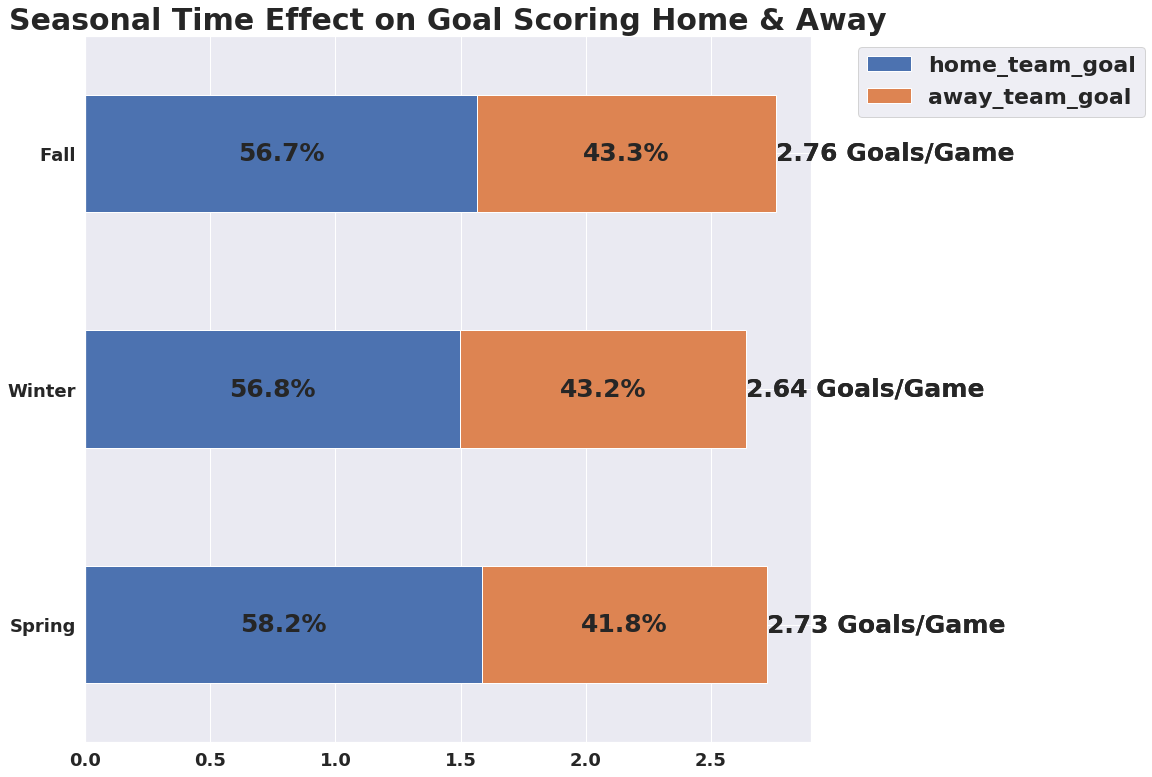


   Seasonal_Time  home_team_goal  away_team_goal  total_goals
0          Fall        1.565385        1.195192     2.760577
1        Winter        1.498958        1.141667     2.640625
2        Spring        1.584615        1.140385     2.725000


In [662]:
plt.rcParams['figure.figsize'] = 13, 13
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "normal"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['axes.labelsize']=18
plt.rcParams['legend.fontsize']: 27
    
goals_viz = total1.groupby('Seasonal_Time')[['home_team_goal', 'away_team_goal', 'total_goals']].mean().reindex(['Spring', 'Winter', 'Fall']).reset_index()

df_total = goals_viz['total_goals']
df = goals_viz.iloc[:, :3]
df.plot(x = 'Seasonal_Time', kind='barh',stacked = True, mark_right = True)

df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(tot, i, str(round(tot, 2)) + ' Goals/Game', va='center')
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='center')

plt.title('Seasonal Time Effect on Goal Scoring Home & Away', fontsize=30,fontweight='bold')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=22)
plt.show()
goals_viz = total1.groupby('Seasonal_Time')[['home_team_goal', 'away_team_goal', 'total_goals']].mean().reindex(['Fall', 'Winter', 'Spring']).reset_index()
print('\n', goals_viz)

# Average Per Game Stats for All Teams Each Season

In [663]:
total = total1[['points','goals_for_home', 'goals_for_away', 'goals_against_home','goals_against_away', 'Seasonal_Time', 'win', 'tie', 'loss']]
total = total.groupby('Seasonal_Time').mean().reindex(['Fall', 'Winter', 'Spring']).reset_index()
total['record'] = ''
for idx, row in total.iterrows():
    total.loc[idx, 'record'] = '(' + str(round(row['win'], 2)) + ')' + '-' + '(' + str(round(row['tie'], 2)) +')' + '-' +'('+ str(round(row['loss'], 2)) + ')'
total = total[['Seasonal_Time', 'record', 'goals_for_home', 'goals_for_away', 'goals_against_home', 'goals_against_away', 'points']]
total.columns = ['Seasonal_Time', 'record (W)-(T)-(L)', 'goals_for(home)', 'goals_for(away)', 'goals_against(home)', 'goals_against(away)', 'points']
print('Every Teams Average Game Stats for the Fall, Winter, and Summer Periods of Each Season')
print('\n', total)
total['goal_diff(home)'] = total['goals_for(home)'] - total['goals_against(home)']
total['goal_diff(away)'] = total['goals_for(away)'] - total['goals_against(away)']
print('\n Goal Difference Simplified')
print('\n', total[['Seasonal_Time', 'record (W)-(T)-(L)', 'goal_diff(home)', 'goal_diff(away)', 'points']])

Every Teams Average Game Stats for the Fall, Winter, and Summer Periods of Each Season

   Seasonal_Time    record (W)-(T)-(L)  goals_for(home)  goals_for(away)  goals_against(home)  goals_against(away)    points
0          Fall  (4.78)-(3.44)-(4.78)         1.567272         1.190245             1.197967             1.563804  1.367788
1        Winter   (4.3)-(3.41)-(4.29)         1.497888         1.138660             1.145861             1.500515  1.357813
2        Spring  (5.03)-(2.94)-(5.03)         1.586988         1.147642             1.140629             1.587255  1.387019

 Goal Difference Simplified

   Seasonal_Time    record (W)-(T)-(L)  goal_diff(home)  goal_diff(away)    points
0          Fall  (4.78)-(3.44)-(4.78)         0.369305        -0.373558  1.367788
1        Winter   (4.3)-(3.41)-(4.29)         0.352027        -0.361855  1.357813
2        Spring  (5.03)-(2.94)-(5.03)         0.446359        -0.439613  1.387019


# Summary: 

# - Most Goals/Game at the Start of Each Season (Teams Adapting to New Players/Coaches/Style Leading to More Vulnerability on Defense?)
# - Winter Was Indeed the Period of the Season in Which Teams Stuggle the Most to Score Goals Home or Away 
# - At the End of Each Season Teams Appear to Become Strongest at Home, Resulting in a worse away form compared to the start of the season (but still better than winter form)




# What About the Champions From Each Season? Are Champions More Consistent or Do They Gain the Most Points During a Certain Part of the Season? 

In [672]:
season_list = list(champs.season)
champion_list = list(champs.Champion)
champ_dfs = []
for i in range(len(champion_list)):    
    dfs = []
    iteration = 0
    for df in [fall, winter, spring]:
        iteration += 1
        df = df.loc[df['season'] == season_list[i]]
        team_df = df.loc[(df['home_team'] == champion_list[i]) | (df['away_team'] == champion_list[i])]
        team_df['goals_for_home'] = np.nan
        team_df['goals_for_away'] = np.nan
        team_df['goals_against_home'] = np.nan
        team_df['goals_against_away'] = np.nan
        team_df['points'] = 0
        team_df['win'] = 0
        team_df['tie'] = 0
        team_df['loss'] = 0
        for idx, row in team_df.iterrows():
            if row['home_team'] == champion_list[i]:
                team_df.loc[idx, 'goals_for_home'] = team_df.loc[idx, 'home_team_goal']
                team_df.loc[idx, 'goals_against_home'] = team_df.loc[idx,'away_team_goal']
                team_df.loc[idx, 'points'] = team_df.loc[idx, 'home_points']
                if row['home_points'] == 3:
                    team_df.loc[idx, 'win'] = 1
                elif row['home_points'] == 1:
                    team_df.loc[idx, 'tie'] = 1
                elif row['home_points'] == 0:
                    team_df.loc[idx, 'loss'] = 1
                team_df.loc[idx, 'points'] = team_df.loc[idx, 'home_points']
            elif row['away_team'] == champion_list[i]:
                team_df.loc[idx, 'goals_for_away'] = team_df.loc[idx, 'away_team_goal']
                team_df.loc[idx, 'goals_against_away'] = team_df.loc[idx, 'home_team_goal']
                team_df.loc[idx, 'points'] = team_df.loc[idx, 'away_points']
                if row['away_points'] == 3:
                    team_df.loc[idx, 'win'] = 1
                elif row['away_points'] == 1:
                    team_df.loc[idx, 'tie'] = 1
                elif row['away_points'] == 0:
                    team_df.loc[idx, 'loss'] = 1
        if iteration == 1:
            team_df['Seasonal_Time'] = 'Fall'
        elif iteration == 2:
            team_df['Seasonal_Time'] = 'Winter'
        else:
            team_df['Seasonal_Time'] = 'Spring'
        win_list = []
        loss_list = []
        tie_list = []
        goals_for_home_list = []
        goals_for_away_list = []
        goals_against_home_list = []
        goals_against_away_list = []
        for season in list(team_df.season.unique()):
            season_df = team_df.loc[team_df['season'] == season]
            win_list.append(sum(season_df['win']))
            tie_list.append(sum(season_df['tie']))
            loss_list.append(sum(season_df['loss']))
            goals_for_home_list.append(np.mean(season_df['goals_for_home']))
            goals_for_away_list.append(np.mean(season_df['goals_for_away']))
            goals_against_home_list.append(np.mean(season_df['goals_against_home']))
            goals_against_away_list.append(np.mean(season_df['goals_against_away']))
        team_df['win'] = np.mean(win_list)
        team_df['tie'] = np.mean(tie_list)
        team_df['loss'] = np.mean(loss_list)
        team_df['goals_for_home'] = np.mean(goals_for_home_list)
        team_df['goals_for_away'] = np.mean(goals_for_away_list)
        team_df['goals_against_home'] = np.mean(goals_against_home_list)
        team_df['goals_against_away'] = np.mean(goals_against_away_list)
        dfs.append(team_df)
    champ_dfs.append(pd.concat(dfs))
champ_season = pd.concat(champ_dfs)
print(champ_season.head(3))    

        season                  league          home_team          away_team  home_team_goal  away_team_goal  home_points  away_points                 date  total_goals  goals_for_home  goals_for_away  goals_against_home  goals_against_away  points  win  tie  loss Seasonal_Time
0    2008/2009  England Premier League  Manchester United   Newcastle United               1               1            1            1  2008-08-17 00:00:00            2             3.0        1.166667            0.666667                 1.0       1  7.0  3.0   2.0          Fall
117  2008/2009  England Premier League         Portsmouth  Manchester United               0               1            0            3  2008-08-25 00:00:00            1             3.0        1.166667            0.666667                 1.0       3  7.0  3.0   2.0          Fall
320  2008/2009  England Premier League          Liverpool  Manchester United               2               1            3            0  2008-09-13 00:00:00        

# Average Per Game Stats For the Champions

In [673]:
champs_season = champ_season[['points','goals_for_home', 'goals_for_away', 'goals_against_home','goals_against_away', 'Seasonal_Time', 'win', 'tie', 'loss']]
champs_season = champs_season.groupby('Seasonal_Time').mean().reindex(['Fall', 'Winter', 'Spring']).reset_index()
champs_season['record'] = ''
for idx, row in champs_season.iterrows():
    champs_season.loc[idx, 'record'] = '(' + str(round(row['win'], 2)) + ')' + '-' + '(' + str(round(row['tie'], 2)) +')' + '-' +'('+ str(round(row['loss'], 2)) + ')'
champs_season = champs_season[['Seasonal_Time', 'record', 'goals_for_home', 'goals_for_away', 'goals_against_home', 'goals_against_away', 'points']]
champs_season.columns = ['Seasonal_Time', 'record (W)-(T)-(L)', 'goals_for(home)', 'goals_for(away)', 'goals_against(home)', 'goals_against(away)', 'points']
print('Every Champions Average Game Stats for the Fall, Winter, and Summer Periods of their Championship Season')
print('\n', champs_season)
champs_season['goal_diff(home)'] = champs_season['goals_for(home)'] - champs_season['goals_against(home)']
champs_season['goal_diff(away)'] = champs_season['goals_for(away)'] - champs_season['goals_against(away)']
print('\n Goal Difference Simplified')
print('\n', champs_season[['Seasonal_Time', 'record (W)-(T)-(L)', 'goal_diff(home)', 'goal_diff(away)', 'points']])

Every Champions Average Game Stats for the Fall, Winter, and Summer Periods of their Championship Season

   Seasonal_Time    record (W)-(T)-(L)  goals_for(home)  goals_for(away)  goals_against(home)  goals_against(away)    points
0          Fall  (9.05)-(2.49)-(1.48)         2.953526         2.015797             0.790751             1.285485  2.269231
1        Winter   (8.53)-(2.4)-(1.23)         2.333481         1.696760             0.613500             0.932450  2.298969
2        Spring  (8.75)-(2.39)-(1.75)         2.456311         1.733934             0.795654             0.934119  2.223301

 Goal Difference Simplified

   Seasonal_Time    record (W)-(T)-(L)  goal_diff(home)  goal_diff(away)    points
0          Fall  (9.05)-(2.49)-(1.48)         2.162775         0.730311  2.269231
1        Winter   (8.53)-(2.4)-(1.23)         1.719980         0.764310  2.298969
2        Spring  (8.75)-(2.39)-(1.75)         1.660656         0.799815  2.223301


# Average Champion ("Champ") Stats vs. Average Stats of All 20 Teams ("Total") Per Season

Record Comparison 

  Seasonal_Time Champion-record (W)-(T)-(L) Total-record (W)-(T)-(L)
0          Fall        (9.05)-(2.49)-(1.48)     (4.78)-(3.44)-(4.78)
1        Winter         (8.53)-(2.4)-(1.23)      (4.3)-(3.41)-(4.29)
2        Spring        (8.75)-(2.39)-(1.75)     (5.03)-(2.94)-(5.03)





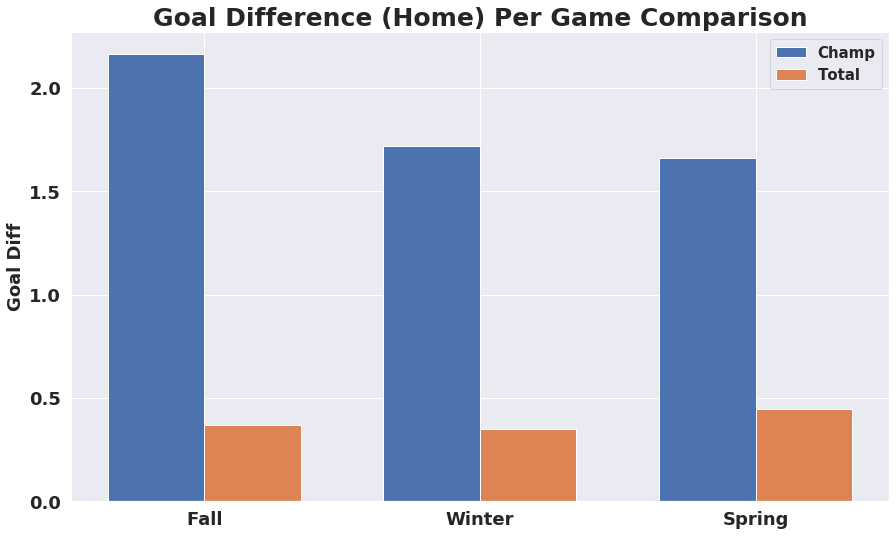

  Seasonal_Time  Champion-goal_diff(home)  Total-goal_diff(home)
0          Fall                  2.162775               0.369305
1        Winter                  1.719980               0.352027
2        Spring                  1.660656               0.446359


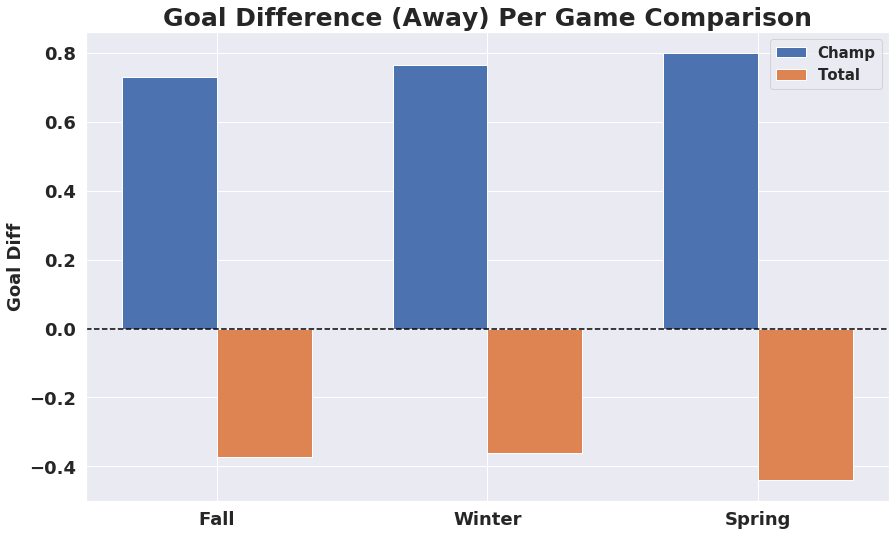

  Seasonal_Time  Champion-goal_diff(away)  Total-goal_diff(away)
0          Fall                  0.730311              -0.373558
1        Winter                  0.764310              -0.361855
2        Spring                  0.799815              -0.439613


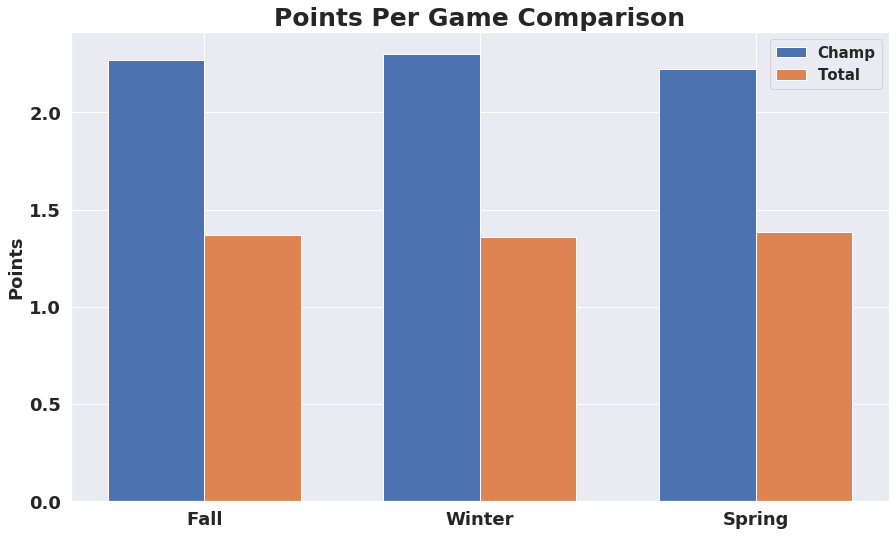

  Seasonal_Time  Champion-points  Total-points
0          Fall         2.269231      1.367788
1        Winter         2.298969      1.357813
2        Spring         2.223301      1.387019


In [627]:
champ_avg = champs_season[['Seasonal_Time', 'record (W)-(T)-(L)', 'goal_diff(home)', 'goal_diff(away)', 'points']]
champ_avg.columns = 'Seasonal_Time', 'Champion-record (W)-(T)-(L)', 'Champion-goal_diff(home)', 'Champion-goal_diff(away)', 'Champion-points'
total_avg = total[['Seasonal_Time', 'record (W)-(T)-(L)', 'goal_diff(home)', 'goal_diff(away)', 'points']]
total_avg.columns = 'Seasonal_Time', 'Total-record (W)-(T)-(L)', 'Total-goal_diff(home)', 'Total-goal_diff(away)', 'Total-points'
compare = pd.merge(total_avg, champ_avg, how='outer')

# Record #
print('Record Comparison', '\n')
print(compare[['Seasonal_Time', 'Champion-record (W)-(T)-(L)', 'Total-record (W)-(T)-(L)']])
print('\n\n')

# Goal Diff(Home) #
diff_home = compare[['Seasonal_Time', 'Champion-goal_diff(home)', 'Total-goal_diff(home)']]
diff_home = diff_home.set_index('Seasonal_Time')

plt.rcParams['figure.figsize'] = 13, 8
labels = diff_home.index
champ_fig = diff_home['Champion-goal_diff(home)']
total_fig = diff_home['Total-goal_diff(home)']
x = np.arange(len(labels))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, champ_fig, width, label='Champ')
rects2 = ax.bar(x + width/2, total_fig, width, label='Total')
ax.set_ylabel('Goal Diff')
plt.title('Goal Difference (Home) Per Game Comparison', fontweight='bold', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=15)
fig.tight_layout()
plt.show()
print(compare[['Seasonal_Time', 'Champion-goal_diff(home)', 'Total-goal_diff(home)']])

# Goal Diff(Home) #
diff_home = compare[['Seasonal_Time', 'Champion-goal_diff(away)', 'Total-goal_diff(away)']]
diff_home = diff_home.set_index('Seasonal_Time')

plt.rcParams['figure.figsize'] = 13, 8
labels = diff_home.index
champ_fig = diff_home['Champion-goal_diff(away)']
total_fig = diff_home['Total-goal_diff(away)']
x = np.arange(len(labels))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, champ_fig, width, label='Champ')
rects2 = ax.bar(x + width/2, total_fig, width, label='Total')
ax.set_ylabel('Goal Diff')
plt.title('Goal Difference (Away) Per Game Comparison', fontweight='bold', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.axhline(y=0, linestyle='--', color='black')
ax.legend(fontsize=15)
fig.tight_layout()
plt.show()
print(compare[['Seasonal_Time', 'Champion-goal_diff(away)', 'Total-goal_diff(away)']])

# Points #
diff_home = compare[['Seasonal_Time', 'Champion-points', 'Total-points']]
diff_home = diff_home.set_index('Seasonal_Time')

plt.rcParams['figure.figsize'] = 13, 8
labels = diff_home.index
champ_fig = diff_home['Champion-points']
total_fig = diff_home['Total-points']
x = np.arange(len(labels)) 
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, champ_fig, width, label='Champ')
rects2 = ax.bar(x + width/2, total_fig, width, label='Total')
ax.set_ylabel('Points')
plt.title('Points Per Game Comparison', fontweight='bold', fontsize=25)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=15)
fig.tight_layout()
plt.show()
print(compare[['Seasonal_Time', 'Champion-points', 'Total-points']])

